In [1]:
import nn_module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import copy
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FixedLocator

In [2]:
out_file = '15708_2'
data_dict = {}
pp = PdfPages(f'./graphs/{out_file}_analysis.pdf')

In [3]:
# The mapping between the WC names and their positions in the data
# There are Combine 1D scans over all 16 WCs
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

# Pairs of WCs in existing Combine 2D scans
WC2d_1 = ['cpQ3', 'cpQM', 'cpt', 'cptb', 'cQei', 'ctei', 'ctli', 'ctW'] # The first of the two WCs to graph
WC2d_2 = ['cbW', 'ctG', 'ctp', 'cQl3i', 'cQlMi', 'ctlTi', 'ctlSi', 'ctZ'] # The second of the two WCs to graph

# Hyperparameters for profiling
profile_parameters = {}
profile_parameters['batch_size'] = 4096
profile_parameters['epochs'] = 100
profile_parameters['learning_rate'] = 2e-0
profile_parameters['lr_red_factor'] = 0.2
profile_parameters['lr_red_patience'] = 5
profile_parameters['lr_red_threshold'] = 1e-6
profile_parameters['rand_pts'] = 50 # The number of random starting points to do gradient descent on for each scanned value
profile_parameters['rand_stdev'] = 40

# general paremeters
batch_size = 4096 # for frozen graphs

In [4]:
save_dict = torch.load(f'../models/{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [5]:
# Check to make sure we're on cuda
input_stats[0].device

device(type='cuda', index=0)

In [6]:
# Check memory usage
torch.cuda.memory_allocated() / 1e9

0.004361728

In [7]:
parameters_save

{'N': 16,
 'train_size': 49378587,
 'test_size': 498773,
 'hidden_nodes': 700,
 'hidden_layers': 2,
 'batch_size': 512,
 'n_epochs': 271,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'polynomial': True,
 'polynomial_degree': 2,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [8]:
best_model_state.keys()

odict_keys(['2.linear.weight', '2.linear.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias'])

In [9]:
# Take Weinberg angle to be 30 degrees.
change_basis = torch.tensor([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0,np.sqrt(3),1,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0,-2,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
                            [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
                            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]).float().cuda()

# Imagine this matrix applied to a vector. The first column of the matrix is what the first entry of the vector 
# gets mapped to, in this case a linear combination of the 10th and 11th WCs.

In [10]:
model = nnm.create_model(16, 1, parameters_save, input_stats, output_stats, change_basis)
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): LinearLayer()
  (1): LinearLayer()
  (2): PolynomialLayer(
    (monomial_layer): MonomialLayer()
    (linear): Linear(in_features=152, out_features=700, bias=True)
  )
  (3): ReLU()
  (4): Linear(in_features=700, out_features=700, bias=True)
  (5): ReLU()
  (6): Linear(in_features=700, out_features=700, bias=True)
  (7): ReLU()
  (8): Linear(in_features=700, out_features=1, bias=True)
  (9): LinearLayer()
)

In [11]:
# Data for 2D frozen graphs
# No comparison to Combine because this is new

model_2d_frozen_data = {}
# WCs to be scanned
idx2d_y = [9] # y axis
idx2d_x = [10] # x axis
res = 300 # How many points per axis
num_inputs = res*res

for idx in np.arange(len(idx2d_y)):
    inputs_y = np.linspace(-2,2,res)
    inputs_x = np.linspace(-7,7,res)
    # Generate the grid
    y_all, x_all = np.meshgrid(inputs_y, inputs_x)
    y_all = y_all.flatten()
    x_all = x_all.flatten()
    inputs = np.zeros((num_inputs, 16))
    inputs[:,idx2d_y[idx]] = y_all
    inputs[:,idx2d_x[idx]] = x_all
    inputs = torch.from_numpy(inputs).float().cuda()
    
    inputMiniBatches = torch.split(inputs, batch_size)
    outputs = torch.zeros((num_inputs, 1)).cuda()
    batch_idx = 0
    for minibatch in range(len(inputMiniBatches)):
        batch_inputs = inputMiniBatches[minibatch]
        this_batch_size = batch_inputs.shape[0]
        outputs[batch_idx: batch_idx + this_batch_size] = model(batch_inputs)
        batch_idx += this_batch_size
    
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs *= 2
    # Save the x and y labels as well. These run from 0 to 15 to be consistent with the change of basis matrix.
    model_2d_frozen_data[str(idx)] = {'y': y_all, 'x': x_all, '2dNLL': outputs, 'y_label': f'x{idx2d_y[idx]}', 'x_label': f'x{idx2d_x[idx]}', 'change_basis': change_basis.cpu().detach().numpy()}

In [12]:
# Save the data
data_dict['model_2d_frozen_data'] = model_2d_frozen_data

In [13]:
# Data for 2D profiled graphs
# No comparison to Combine because this is new

model_2d_profiled_data = {}
# WCs to be scanned
# WARNING: Change names here and in graphing if you want to scan different WCs than for the frozen graphs
idx2d_y = [9] # y axis
idx2d_x = [10] # x axis
res = 300 # How many points per axis
num_inputs = res*res

for idx in np.arange(len(idx2d_y)):
    inputs_y = np.linspace(-2.5,2.5,res)
    inputs_x = np.linspace(-7.5,7.5,res)
    # Generate the grid
    y_all, x_all = np.meshgrid(inputs_y, inputs_x)
    y_all = y_all.flatten()
    x_all = x_all.flatten()
    inputs = np.zeros((num_inputs, 16))
    inputs[:,idx2d_y[idx]] = y_all
    inputs[:,idx2d_x[idx]] = x_all
    (min_WCs_scanned, outputs) = nnm.profile(model, inputs, [idx2d_y[idx], idx2d_x[idx]], profile_parameters)
    min_WCs_scanned = min_WCs_scanned.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs *= 2
    model_2d_profiled_data[str(idx)] = {'all_WCs': min_WCs_scanned, 'y': y_all, 'x': x_all, '2dNLL': outputs, 'y_label': f'x{idx2d_y[idx]}', 'x_label': f'x{idx2d_x[idx]}', 'change_basis': change_basis.cpu().detach().numpy()}

WC indices: 9 10 Starting 0/22 minibatches.
Starting 0/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1348416.25
Starting 1/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1295372.5
Starting 2/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1243153.0
Starting 3/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1193240.375
Starting 4/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1145557.5
Starting 5/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1101119.5
Starting 6/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1061769.0
Starting 7/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1029189.5625
Starting 8/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1005856.125
Starting 9/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 993739.0625
Starting 10/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 990537.0625
Starting

Sum(log(minibatch outputs+10)): 903909.75
Starting 95/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 903908.0
Starting 96/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 903906.125
Starting 97/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 903904.375
Starting 98/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 903903.1875
Starting 99/100 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 903901.75
WC indices: 9 10 Starting 1/22 minibatches.
Starting 0/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 1346166.0
Starting 1/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 1291942.625
Starting 2/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 1238226.25
Starting 3/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 1186500.375
Starting 4/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 1136590.75
Starting 5/100 epochs of 1/22 minibatches.
Sum(log

Starting 89/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863613.5
Starting 90/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863610.125
Starting 91/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863607.0
Starting 92/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863604.75
Starting 93/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863602.0
Starting 94/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863599.6875
Starting 95/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863597.6875
Starting 96/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863595.625
Starting 97/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863594.25
Starting 98/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863592.9375
Starting 99/100 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 863591.25
WC indices: 9 10 Starting 2/22 minibatches.
Start

Starting 84/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 828005.875
Starting 85/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 828000.125
Starting 86/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827995.0
Starting 87/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827989.125
Starting 88/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827986.25
Starting 89/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827981.375
Starting 90/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827977.625
Starting 91/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827973.9375
Starting 92/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827971.5
Starting 93/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827968.3125
Starting 94/100 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 827965.875
Starting 95/100 epochs of 2/22 minibatches.
Su

Starting 79/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809976.1875
Starting 80/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809963.375
Starting 81/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809955.125
Starting 82/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809946.25
Starting 83/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809939.25
Starting 84/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809929.25
Starting 85/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809924.1875
Starting 86/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809917.625
Starting 87/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809913.25
Starting 88/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809907.125
Starting 89/100 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 809903.375
Starting 90/100 epochs of 3/22 minibatches.
S

Starting 74/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778162.625
Starting 75/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778141.5
Starting 76/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778123.25
Starting 77/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778104.375
Starting 78/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778088.4375
Starting 79/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778074.125
Starting 80/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778061.3125
Starting 81/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778048.6875
Starting 82/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778039.5
Starting 83/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778028.375
Starting 84/100 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 778020.0625
Starting 85/100 epochs of 4/22 minibatches.


Sum(log(minibatch outputs+10)): 754049.125
Starting 69/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 754006.6875
Starting 70/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753967.375
Starting 71/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753931.4375
Starting 72/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753896.9375
Starting 73/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753865.25
Starting 74/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753836.75
Starting 75/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753812.625
Starting 76/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753787.8125
Starting 77/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753766.4375
Starting 78/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753748.0
Starting 79/100 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 753729.062

Starting 64/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747865.5
Starting 65/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747797.875
Starting 66/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747736.9375
Starting 67/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747678.875
Starting 68/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747625.125
Starting 69/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747578.875
Starting 70/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747536.125
Starting 71/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747492.8125
Starting 72/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747455.3125
Starting 73/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747421.8125
Starting 74/100 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 747389.3125
Starting 75/100 epochs of 6/22 minibatch

Starting 59/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 732413.9375
Starting 60/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 732310.5625
Starting 61/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 732211.25
Starting 62/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 732122.9375
Starting 63/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 732041.5
Starting 64/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 731966.25
Starting 65/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 731895.25
Starting 66/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 731831.5
Starting 67/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 731770.875
Starting 68/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 731716.5
Starting 69/100 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 731664.9375
Starting 70/100 epochs of 7/22 minibatches.
Sum(

Sum(log(minibatch outputs+10)): 719885.0
Starting 54/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 719700.9375
Starting 55/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 719536.0625
Starting 56/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 719388.0625
Starting 57/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 719255.5
Starting 58/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 719129.6875
Starting 59/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 719014.375
Starting 60/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 718906.375
Starting 61/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 718805.25
Starting 62/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 718718.25
Starting 63/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 718633.25
Starting 64/100 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 718560.125
Sta

Starting 48/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 722852.0
Starting 49/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 722588.125
Starting 50/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 722335.625
Starting 51/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 722104.4375
Starting 52/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 721885.8125
Starting 53/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 721689.75
Starting 54/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 721508.6875
Starting 55/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 721347.75
Starting 56/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 721196.125
Starting 57/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 721064.875
Starting 58/100 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 720944.375
Starting 59/100 epochs of 9/22 minibatches.


Starting 43/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 722014.125
Starting 44/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 721568.375
Starting 45/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 721170.125
Starting 46/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 720802.75
Starting 47/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 720464.375
Starting 48/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 720153.1875
Starting 49/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 719873.1875
Starting 50/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 719615.625
Starting 51/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 719375.9375
Starting 52/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 719160.0
Starting 53/100 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 718958.25
Starting 54/100 epochs of 10/22 m

Starting 36/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 720493.0
Starting 37/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 719608.875
Starting 38/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 718776.875
Starting 39/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 718024.4375
Starting 40/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 717368.0625
Starting 41/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 716785.1875
Starting 42/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 716259.125
Starting 43/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 715759.5625
Starting 44/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 715310.8125
Starting 45/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 714905.5
Starting 46/100 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 714529.875
Starting 47/100 epochs of 11/22

Starting 29/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 736780.625
Starting 30/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 735210.25
Starting 31/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 733811.125
Starting 32/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 732468.125
Starting 33/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 731238.1875
Starting 34/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 730121.6875
Starting 35/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 729179.875
Starting 36/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 728301.25
Starting 37/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 727449.875
Starting 38/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 726643.625
Starting 39/100 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 725890.3125
Starting 40/100 epochs of 12/22

Starting 23/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 759566.5
Starting 24/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 756732.3125
Starting 25/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 754236.5
Starting 26/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 751984.375
Starting 27/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 749812.5
Starting 28/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 747790.75
Starting 29/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 746039.75
Starting 30/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 744547.25
Starting 31/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 743156.375
Starting 32/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 741843.375
Starting 33/100 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 740597.25
Starting 34/100 epochs of 13/22 minibatch

Sum(log(minibatch outputs+10)): 792741.625
Starting 17/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 787607.5
Starting 18/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 781514.5625
Starting 19/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 775388.125
Starting 20/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 770660.0625
Starting 21/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 767102.0
Starting 22/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 763998.875
Starting 23/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 760983.375
Starting 24/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 758085.75
Starting 25/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 755496.75
Starting 26/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 753154.25
Starting 27/100 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 75099

Sum(log(minibatch outputs+10)): 893348.1875
Starting 10/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 883115.75
Starting 11/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 875606.125
Starting 12/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 862145.875
Starting 13/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 844270.0
Starting 14/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 826557.0
Starting 15/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 814029.5
Starting 16/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 807249.875
Starting 17/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 801853.75
Starting 18/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 795570.375
Starting 19/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 789405.875
Starting 20/100 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 784809.

Sum(log(minibatch outputs+10)): 1170818.75
Starting 4/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1115347.125
Starting 5/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1061031.375
Starting 6/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1010000.4375
Starting 7/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 965003.5
Starting 8/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 929781.9375
Starting 9/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 908643.375
Starting 10/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 899666.6875
Starting 11/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 893236.75
Starting 12/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 881042.875
Starting 13/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 864297.0
Starting 14/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 84759

Sum(log(minibatch outputs+10)): 768657.3125
Starting 98/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 768651.625
Starting 99/100 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 768646.375
WC indices: 9 10 Starting 17/22 minibatches.
Starting 0/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1342335.625
Starting 1/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1285638.25
Starting 2/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1228960.375
Starting 3/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1173630.375
Starting 4/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1119018.25
Starting 5/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1065734.125
Starting 6/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 1015811.4375
Starting 7/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 971969.1875
Starting 8/100 epochs of 17/22 m

Sum(log(minibatch outputs+10)): 781156.625
Starting 92/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781151.125
Starting 93/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781147.875
Starting 94/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781142.6875
Starting 95/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781138.1875
Starting 96/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781135.125
Starting 97/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781131.1875
Starting 98/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781131.375
Starting 99/100 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 781128.625
WC indices: 9 10 Starting 18/22 minibatches.
Starting 0/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 1343319.125
Starting 1/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 1287527.25
Starting 2/100 epochs of 18/22

Starting 85/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809258.4375
Starting 86/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809251.625
Starting 87/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809246.3125
Starting 88/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809241.125
Starting 89/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809238.0
Starting 90/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809232.0
Starting 91/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809230.375
Starting 92/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809224.75
Starting 93/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809226.1875
Starting 94/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809224.125
Starting 95/100 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 809220.4375
Starting 96/100 epochs of 18/22 m

Starting 78/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846916.25
Starting 79/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846907.25
Starting 80/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846896.375
Starting 81/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846889.875
Starting 82/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846882.125
Starting 83/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846875.5
Starting 84/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846871.375
Starting 85/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846864.4375
Starting 86/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846860.5
Starting 87/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846855.625
Starting 88/100 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 846852.875
Starting 89/100 epochs of 19/22 minib

Starting 72/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869831.5
Starting 73/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869815.0
Starting 74/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869799.4375
Starting 75/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869786.9375
Starting 76/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869773.375
Starting 77/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869762.25
Starting 78/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869753.0625
Starting 79/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869742.75
Starting 80/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869736.3125
Starting 81/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869728.4375
Starting 82/100 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 869721.875
Starting 83/100 epochs of 20/22 m

Starting 65/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885797.5
Starting 66/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885769.125
Starting 67/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885743.125
Starting 68/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885720.875
Starting 69/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885699.25
Starting 70/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885680.0
Starting 71/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885662.5
Starting 72/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885647.25
Starting 73/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885632.75
Starting 74/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885620.875
Starting 75/100 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 885608.1875
Starting 76/100 epochs of 21/22 minibatc

In [14]:
# Save the data
data_dict['model_2d_profiled_data'] = model_2d_profiled_data

In [15]:
# Make the graphs

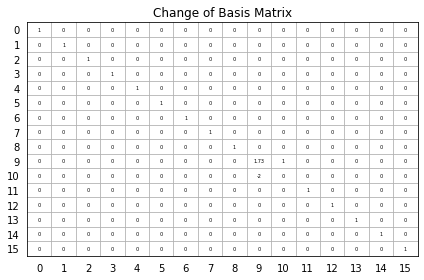

In [16]:
# Print the change of basis matrix first
change_basis_graph = plt.subplots()
#change_basis_graph[1].matshow(model_2d_frozen_data['0']['change_basis'], cmap=plt.cm.Blues)
for i in np.arange(change_basis.shape[0]):
    for j in np.arange(change_basis.shape[1]):
        c = model_2d_frozen_data['0']['change_basis'][j,i]
        change_basis_graph[1].text(i, j, f'{c:.3g}', va='center', ha='center', size=5)
change_basis_graph[1].set_xlim(-0.5, change_basis.shape[1]-0.5)
change_basis_graph[1].set_ylim(change_basis.shape[0]-0.5, -0.5)
change_basis_graph[1].set_xticks(np.arange(0, change_basis.shape[1], 1))
change_basis_graph[1].set_yticks(np.arange(0, change_basis.shape[0], 1))
change_basis_graph[1].xaxis.set_minor_locator(FixedLocator(np.arange(0.5, change_basis.shape[1]+1.5, 1)))
change_basis_graph[1].yaxis.set_minor_locator(FixedLocator(np.arange(0.5, change_basis.shape[0]+1.5, 1)))
change_basis_graph[1].grid(which='minor')
change_basis_graph[1].xaxis.set_tick_params(which='major', bottom=False)
change_basis_graph[1].yaxis.set_tick_params(which='major', bottom=False)
change_basis_graph[1].xaxis.set_tick_params(which='minor', bottom=False)
change_basis_graph[1].yaxis.set_tick_params(which='minor', bottom=False)
change_basis_graph[1].set_title('Change of Basis Matrix')
change_basis_graph[0].tight_layout()

In [17]:
# Save the graphs
pp.savefig(change_basis_graph[0])

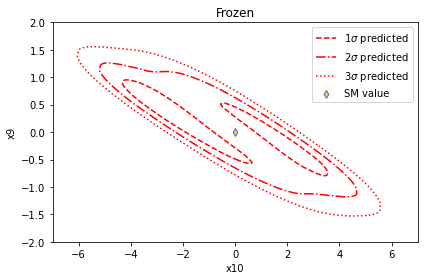

In [18]:
# 2D frozen graphs
frozen_2d_graphs = {}
for idx in np.arange(len(idx2d_y)):
    model_2d_frozen_data[str(idx)]['2dNLL'] -= model_2d_frozen_data[str(idx)]['2dNLL'].min()
    frozen_2d_graphs[str(idx)] = plt.subplots()
    model_contour = frozen_2d_graphs[str(idx)][1].tricontour(model_2d_frozen_data[str(idx)]['x'], model_2d_frozen_data[str(idx)]['y'], model_2d_frozen_data[str(idx)]['2dNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = frozen_2d_graphs[str(idx)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    frozen_2d_graphs[str(idx)][1].legend(model_contour.collections+[SM_value], ['$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    frozen_2d_graphs[str(idx)][1].set_xlabel(model_2d_frozen_data[str(idx)]['x_label'])
    frozen_2d_graphs[str(idx)][1].set_ylabel(model_2d_frozen_data[str(idx)]['y_label'])
    frozen_2d_graphs[str(idx)][1].set_title('Frozen')
    frozen_2d_graphs[str(idx)][0].tight_layout()

In [19]:
# Save the graphs
for key in frozen_2d_graphs.keys():
    pp.savefig(frozen_2d_graphs[key][0])

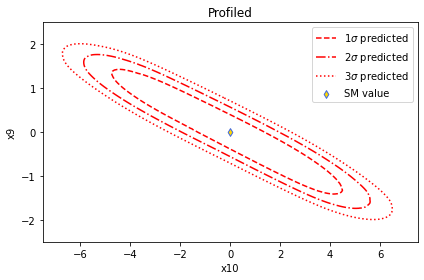

In [20]:
# 2D profiled graphs
profiled_2d_graphs = {}
for idx in np.arange(len(idx2d_y)):
    model_2d_profiled_data[str(idx)]['2dNLL'] -= model_2d_profiled_data[str(idx)]['2dNLL'].min()
    profiled_2d_graphs[str(idx)] = plt.subplots()
    model_contour = profiled_2d_graphs[str(idx)][1].tricontour(model_2d_profiled_data[str(idx)]['x'], model_2d_profiled_data[str(idx)]['y'], model_2d_profiled_data[str(idx)]['2dNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = profiled_2d_graphs[str(idx)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    profiled_2d_graphs[str(idx)][1].legend(model_contour.collections+[SM_value], ['$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    profiled_2d_graphs[str(idx)][1].set_xlabel(model_2d_profiled_data[str(idx)]['x_label'])
    profiled_2d_graphs[str(idx)][1].set_ylabel(model_2d_profiled_data[str(idx)]['y_label'])
    profiled_2d_graphs[str(idx)][1].set_title('Profiled')
    profiled_2d_graphs[str(idx)][0].tight_layout()

In [21]:
# Save the graphs
for key in profiled_2d_graphs.keys():
    pp.savefig(profiled_2d_graphs[key][0])

In [22]:
# Save the graphs and data to files
np.savez(f'./graphs/{out_file}_analysis.npz', **data_dict)
pp.close()